In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import scipy.io as sio
import dnatools
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=14


/net/gs/vol3/software/modules-sw-python/2.7.3/pandas/0.14.0/Linux/RHEL6/x86_64/lib/python2.7/site-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


### Make directory to save results:

In [2]:
resultsdir = '../results/N8_HAL_Genome_Predictions/'
if not os.path.exists(resultsdir):
    os.makedirs(resultsdir)
figdir = '../figures/N8_HAL_Genome_Predictions/'
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
#Choose if you want to actually save the plots:
SAVEFIGS = True

### Load other splice site models:

In [3]:
f = open('../ref/MAXENT_ALL_SD.txt')
all_ss_scores = {'MAXENT':{},
                 'MDD':{},
                 'MM':{},
                 'WMM':{}
                 }
while True:
    line =  f.readline()[:-1]
    line =  f.readline()[:-1]
    if len(line)==0:
        break
    all_ss_scores['MAXENT'][line.split('\t')[0]] = float(line.split('\t')[1][8:])
    all_ss_scores['MDD'][line.split('\t')[0]] = float(line.split('\t')[2][5:])
    all_ss_scores['MM'][line.split('\t')[0]] = float(line.split('\t')[3][4:])
    all_ss_scores['WMM'][line.split('\t')[0]] = float(line.split('\t')[4][5:])
f.close()

def score_ss(seq,ss_scores):
    return -ss_scores[seq[198:198+9]]+ss_scores[seq[-203:-203+9]]

### Load HAL:

In [4]:
data = sio.loadmat('../results/N7_A5SS_Model_Predictions/model_full_data.mat')
w = data['Mer_scores'][:4**6*8]
mer6_dict = dict(zip(dnatools.make_mer_list(6),range(4**6)))
w_mat = w.reshape(4**6,size(w)/4**6)
logit = lambda x: log(x)-log(1-x)
expit = lambda x: 1./(1.+exp(-x))

def score_seq_pos(seq):
    seq_scores = np.zeros(160)
    for b in range(40):
        seq_scores[b:b+6] += w_mat[mer6_dict[seq[b:b+6]],0]/6.
    for b in range(40,70):
        seq_scores[b:b+6] += w_mat[mer6_dict[seq[b:b+6]],1]/6.
    for b in [77]:
        seq_scores[b:b+6] += w_mat[mer6_dict[seq[b:b+6]],2]/6.
    for b in [78]:
        seq_scores[b:b+6] += w_mat[mer6_dict[seq[b:b+6]],3]/6.
    for b in [79]:
        seq_scores[b:b+6] += w_mat[mer6_dict[seq[b:b+6]],4]/6.
    for b in [80]:
        seq_scores[b:b+6] += w_mat[mer6_dict[seq[b:b+6]],5]/6.
    for b in range(86,120-5):
        seq_scores[b:b+6] += w_mat[mer6_dict[seq[b:b+6]],6]/6.
    for b in range(115,155):
        seq_scores[b:b+6] += w_mat[mer6_dict[seq[b:b+6]],7]/6.
    return seq_scores

def predict_prob(seq):
    sd1_score = sum(score_seq_pos(seq[201-80:201+80]))
    sd2_score = sum(score_seq_pos(seq[-200-80:-200+80]))
    return sd2_score-sd1_score

### Load SNP data:

In [5]:
A5SS_data = pd.read_csv(resultsdir+'A5SS_Miso_events.csv',index_col=0)

### Only include Events Found in 10 Samples

In [6]:
A5SS_data_filtered = A5SS_data[A5SS_data.sample_num>=10]

In [7]:
preds_comp = {}
preds_comp['HAL'] = expit(A5SS_data_filtered['Seqs'].apply(predict_prob))
for alg in all_ss_scores.keys():
    preds_comp['$\Delta$'+alg] = A5SS_data_filtered['Seqs'].apply(lambda s:score_ss(s,all_ss_scores[alg]))

In [8]:
prediction_df = pd.DataFrame(preds_comp).join(A5SS_data_filtered)

In [9]:
prediction_df[[u'sample_num',
                     u'miso_posterior_mean',
                     u'ci_low',
                     u'ci_high',
                     u'HAL',
                     u'$\Delta$MAXENT',
                     u'$\Delta$MDD',
                     u'$\Delta$MM',
                     u'$\Delta$WMM',
                    ]].to_csv(resultsdir+'A5SS_MISO_Event_Predictions.csv')

In [10]:
dists = A5SS_data_filtered.Seqs.apply(len).order()-400
bin_edges = []
for i in arange(0,1.0,0.2):
    bin_edges.append(dists.values[np.round(i*len(dists))])
bin_edges.append(5000)

/net/shendure/vol1/home/abros/VirtualEnvs/analysisenv/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [11]:
dist_strs = []
preds_r2 = []
ss_compar_r2 = {}
for alg in preds_comp.keys():
    ss_compar_r2[alg]=[]


for i in range(5):
    dist_strs.append(str(bin_edges[i])+'-'+str(bin_edges[i+1]-1))
    events = A5SS_data_filtered[((A5SS_data_filtered.Seqs.apply(len)-400)>=bin_edges[i]) & ((A5SS_data_filtered.Seqs.apply(len)-400)<bin_edges[i+1])].index
    for alg in preds_comp.keys():
        ss_compar_r2[alg].append(scipy.stats.pearsonr(preds_comp[alg][events],A5SS_data_filtered.miso_posterior_mean[events])[0]**2)
    #preds_r2.append(scipy.stats.pearsonr(expit(preds[events]),A5SS_data_filtered.miso_posterior_mean[events])[0]**2)
    
#ss_compar_r2['HAL'] = preds_r2

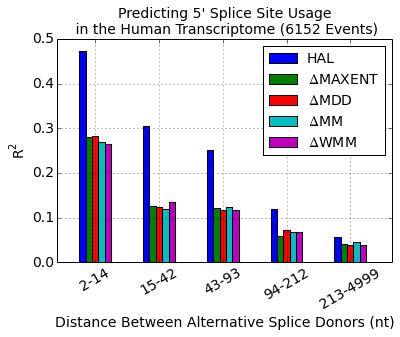

In [12]:
fig = figure()
ax = fig.add_subplot(111)
dist_pred_df = pd.DataFrame(ss_compar_r2)
dist_pred_df.index=dist_strs
dist_pred_df.iloc[:,[4,0,1,2,3]].plot(ax=ax,kind='bar')
ax.tick_params(labelsize=fsize)
ax.set_xlabel('Distance Between Alternative Splice Donors (nt)',fontsize=fsize)
ax.set_ylabel('$R^2$',fontsize=fsize)
ax.set_title("Predicting 5' Splice Site Usage\n in the Human Transcriptome (6152 Events)",fontsize=14)
ax.set_xticklabels(dist_pred_df.index.values,rotation=30)
leg = ax.legend(fontsize=fsize)
if SAVEFIGS:
    figname = 'HAL_A5SS_comparisons_grouped_by_distance'
    fig.savefig(figdir+figname+'.pdf',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.eps',dpi=300,bbox_inches='tight')
    fig.savefig(figdir+figname+'.png',dpi=300,bbox_inches='tight')


In [13]:
len(A5SS_data_filtered)

6152